# Lesson 3 Module 5: Bootstrap

This notebook demonstrates bootstrap methods for confidence interval construction.
It complements parametric confidence intervals and builds on Lesson 1 (sampling distributions).

## Learning Objectives
- Explain the bootstrap idea: resampling to approximate sampling distributions
- Implement percentile and basic bootstrap confidence intervals
- Apply bootstrap to non-smooth statistics (median, quantiles)
- Compare bootstrap CI coverage to parametric methods

## Repository Context
- Uses `bootstrap_stat()` function from the appendix
- Uses `shared/data/heights_weights_sample.csv` for practical examples
- Complements confidence intervals from previous module

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style and random seed
sns.set_theme(context="talk", style="whitegrid")
sns.set_palette(["#000000", "#E69F00", "#56B4E9", "#009E73",
                 "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
rng = np.random.default_rng(2025)

print("Environment setup complete. Random seed: 2025")

Environment setup complete. Random seed: 2025


## 1. Bootstrap Function

Using the bootstrap function from the appendix.


### Understanding the Bootstrap Intervals

- **Percentile (quantile) interval.** Treat the $B$ bootstrap values as a stand-in for the sampling distribution of $T$. The lower endpoint is simply the $\alpha/2$ quantile of the bootstrap values and the upper endpoint is the $(1-\alpha/2)$ quantile. In other words we ask: “in how many of the resamples was the statistic smaller than the observed one?” and read the cut-offs directly from those counts.

- **Basic (reverse) interval.** Start from the same bootstrap quantiles, but mirror them around the observed statistic. If the bootstrap distribution tends to sit above the observed value (suggesting positive bias), the reflection pulls the lower limit down and the upper limit up by the same amount, centring the interval at the observed statistic. Formally this gives $[2T - \hat q_{1-\alpha/2},\, 2T - \hat q_{\alpha/2}]$.

You can think of the percentile interval as “look at where the bootstrap replicates fall,” while the basic interval says “measure how far the bootstrap replicates fall from $T$ and mirror those distances to correct simple bias.”



In [56]:
def bootstrap_stat(x, stat_fn, B=10_000, alpha=0.05, rng=None):
    """
    Nonparametric bootstrap for a scalar statistic.
    Returns (thetahat, replicates, ci_percentile, ci_basic).
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(x)
    thetahat = stat_fn(x)
    boots = np.empty(B)
    for b in range(B):
        xb = x[rng.integers(0, n, n)]
        boots[b] = stat_fn(xb)
    lo_p, hi_p = np.quantile(boots, [alpha/2, 1-alpha/2])
    ci_percentile = (lo_p, hi_p)
    ci_basic = (2*thetahat - hi_p, 2*thetahat - lo_p)
    return thetahat, boots, ci_percentile, ci_basic

print("Function defined: bootstrap_stat")

Function defined: bootstrap_stat


## 2. Bootstrap for Median (Exponential Data)

Demonstrate bootstrap for a non-smooth statistic where parametric methods are difficult.

In [40]:
# Generate skewed exponential data
true_lambda = 2.0
n = 100
x = rng.exponential(1/true_lambda, n)

print(f"Generated {n} exponential observations (λ = {true_lambda})")
print(f"Sample median: {np.median(x):.4f}")
print(f"Theoretical median: {np.log(2)/true_lambda:.4f}")

Generated 100 exponential observations (λ = 2.0)
Sample median: 0.3358
Theoretical median: 0.3466


In [41]:
# Bootstrap the median
sample_median, boot_medians, ci_percentile, ci_basic = bootstrap_stat(
    x, np.median, B=5000, alpha=0.05, rng=rng
)

print(f"Sample median: {sample_median:.4f}")
print(f"Percentile CI: [{ci_percentile[0]:.4f}, {ci_percentile[1]:.4f}]")
print(f"Basic CI: [{ci_basic[0]:.4f}, {ci_basic[1]:.4f}]")
print(f"True median: {np.log(2)/true_lambda:.4f}")
print(f"Percentile CI contains true value: {ci_percentile[0] <= np.log(2)/true_lambda <= ci_percentile[1]}")
print(f"Basic CI contains true value: {ci_basic[0] <= np.log(2)/true_lambda <= ci_basic[1]}")

Sample median: 0.3358
Percentile CI: [0.2684, 0.5148]
Basic CI: [0.1567, 0.4032]
True median: 0.3466
Percentile CI contains true value: True
Basic CI contains true value: True


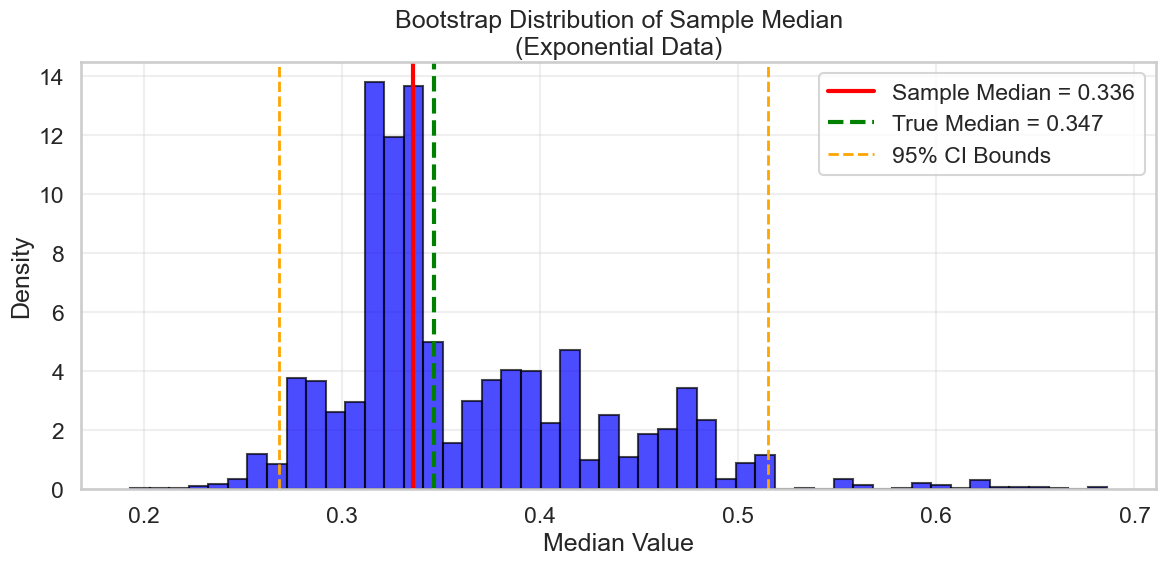

Bootstrap median distribution plot saved


In [42]:
# Plot bootstrap distribution of median
plt.figure(figsize=(12, 6))

# Histogram of bootstrap medians
plt.hist(boot_medians, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')

# Vertical lines
plt.axvline(sample_median, color='red', linewidth=3, label=f'Sample Median = {sample_median:.3f}')
plt.axvline(np.log(2)/true_lambda, color='green', linewidth=3, linestyle='--', label=f'True Median = {np.log(2)/true_lambda:.3f}')
plt.axvline(ci_percentile[0], color='orange', linewidth=2, linestyle='--', label='95% CI Bounds')
plt.axvline(ci_percentile[1], color='orange', linewidth=2, linestyle='--')

plt.xlabel('Median Value')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Sample Median\n(Exponential Data)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../slides/figures/bootstrap_median_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Bootstrap median distribution plot saved")

## 3. Bootstrap for Difference in Means

Using heights data to compare bootstrap vs parametric intervals for mean difference.

In [43]:
# Load heights data
heights_df = pd.read_csv("../../../shared/data/heights_weights_sample.csv")
print("Heights data shape:", heights_df.shape)
print("Columns:", heights_df.columns.tolist())

# Separate by sex
male_heights = heights_df[heights_df['sex'] == 'M']['height_cm'].values
female_heights = heights_df[heights_df['sex'] == 'F']['height_cm'].values

print(f"\nMale heights: n = {len(male_heights)}, mean = {np.mean(male_heights):.2f} cm")
print(f"Female heights: n = {len(female_heights)}, mean = {np.mean(female_heights):.2f} cm")
print(f"Mean difference: {np.mean(male_heights) - np.mean(female_heights):.2f} cm")

Heights data shape: (10, 4)
Columns: ['id', 'height_cm', 'weight_kg', 'sex']

Male heights: n = 5, mean = 177.60 cm
Female heights: n = 5, mean = 162.80 cm
Mean difference: 14.80 cm


In [44]:
# Parametric Welch CI
def welch_ci(x1, x2, alpha=0.05):
    """Welch's t-interval for difference in means"""
    n1, n2 = len(x1), len(x2)
    mean1, mean2 = np.mean(x1), np.mean(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)

    # Welch-Satterthwaite degrees of freedom
    se1, se2 = var1/n1, var2/n2
    df_num = (se1 + se2)**2
    df_den = se1**2/(n1-1) + se2**2/(n2-1)
    df = df_num / df_den

    diff = mean1 - mean2
    se_diff = np.sqrt(se1 + se2)
    t_crit = stats.t.ppf(1 - alpha/2, df)

    return diff - t_crit*se_diff, diff + t_crit*se_diff

# Compute parametric CI
welch_lo, welch_hi = welch_ci(male_heights, female_heights)
print(f"Welch CI: [{welch_lo:.3f}, {welch_hi:.3f}] (length: {welch_hi-welch_lo:.3f})")

Welch CI: [7.552, 22.048] (length: 14.496)


In [45]:
# Bootstrap CI for difference in means
def mean_difference(x1, x2):
    return np.mean(x1) - np.mean(x2)

def bootstrap_two_sample(x1, x2, stat_fn, B=5000, alpha=0.05, rng=None):
    """Bootstrap for two-sample statistic"""
    rng = np.random.default_rng() if rng is None else rng
    n1, n2 = len(x1), len(x2)
    thetahat = stat_fn(x1, x2)
    boots = np.empty(B)

    for b in range(B):
        x1_boot = x1[rng.integers(0, n1, n1)]
        x2_boot = x2[rng.integers(0, n2, n2)]
        boots[b] = stat_fn(x1_boot, x2_boot)

    lo_p, hi_p = np.quantile(boots, [alpha/2, 1-alpha/2])
    ci_percentile = (lo_p, hi_p)
    ci_basic = (2*thetahat - hi_p, 2*thetahat - lo_p)

    return thetahat, boots, ci_percentile, ci_basic

# Bootstrap the difference
boot_diff, boot_diffs, boot_percentile, boot_basic = bootstrap_two_sample(
    male_heights, female_heights, mean_difference, B=5000, rng=rng
)

print(f"Bootstrap difference: {boot_diff:.3f}")
print(f"Bootstrap percentile CI: [{boot_percentile[0]:.3f}, {boot_percentile[1]:.3f}]")
print(f"Bootstrap basic CI: [{boot_basic[0]:.3f}, {boot_basic[1]:.3f}]")

Bootstrap difference: 14.800
Bootstrap percentile CI: [9.400, 20.000]
Bootstrap basic CI: [9.600, 20.200]


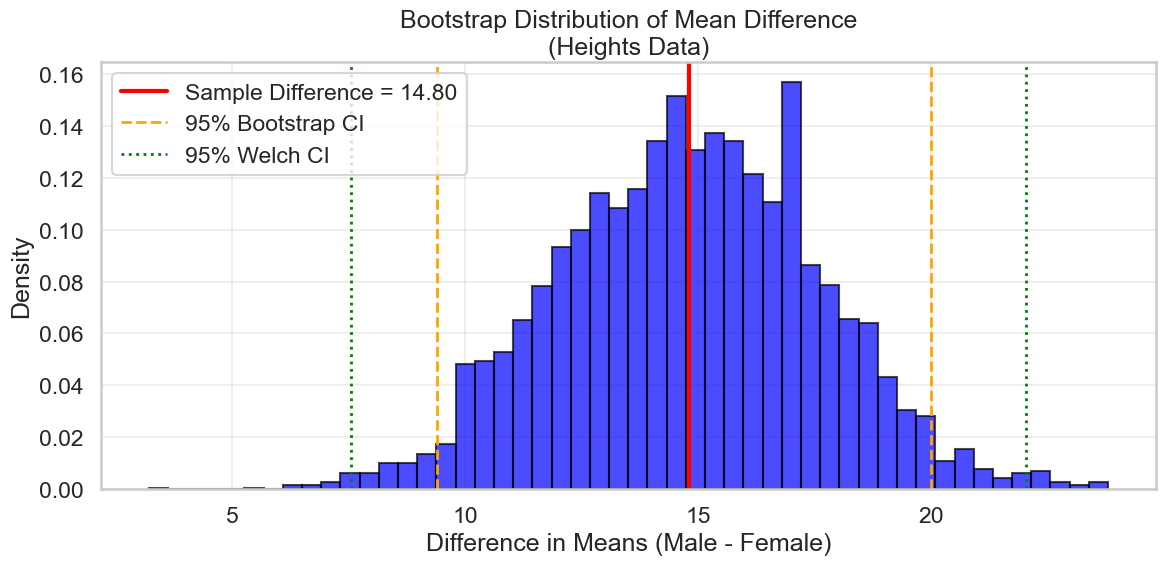

Bootstrap mean difference plot saved


In [46]:
# Plot bootstrap distribution of difference
plt.figure(figsize=(12, 6))

plt.hist(boot_diffs, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')

# Vertical lines
plt.axvline(boot_diff, color='red', linewidth=3, label=f'Sample Difference = {boot_diff:.2f}')
plt.axvline(boot_percentile[0], color='orange', linewidth=2, linestyle='--', label='95% Bootstrap CI')
plt.axvline(boot_percentile[1], color='orange', linewidth=2, linestyle='--')
plt.axvline(welch_lo, color='green', linewidth=2, linestyle=':', label='95% Welch CI')
plt.axvline(welch_hi, color='green', linewidth=2, linestyle=':')

plt.xlabel('Difference in Means (Male - Female)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Mean Difference\n(Heights Data)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../slides/figures/bootstrap_mean_difference.png', dpi=150, bbox_inches='tight')
plt.show()

print("Bootstrap mean difference plot saved")

## 4. Studentized Bootstrap

Implement studentized bootstrap for improved performance.

In [47]:
def studentized_bootstrap(x, stat_fn, B=5000, alpha=0.05, rng=None):
    """
    Studentized bootstrap for improved CI coverage.
    """
    rng = np.random.default_rng() if rng is None else rng
    n = len(x)
    thetahat = stat_fn(x)

    # Bootstrap statistics and standard errors
    boot_stats = np.empty(B)
    boot_ses = np.empty(B)

    for b in range(B):
        xb = x[rng.integers(0, n, n)]
        boot_stats[b] = stat_fn(xb)
        boot_ses[b] = np.std(xb, ddof=1) / np.sqrt(n)  # SE of mean

    # Studentized statistics
    se_hat = np.std(x, ddof=1) / np.sqrt(n)
    studentized = (boot_stats - thetahat) / boot_ses

    # Quantiles of studentized statistics
    q_lo, q_hi = np.quantile(studentized, [alpha/2, 1-alpha/2])

    # Studentized CI
    ci_studentized = (thetahat - q_hi * se_hat, thetahat - q_lo * se_hat)

    return thetahat, boot_stats, ci_studentized

print("Function defined: studentized_bootstrap")

Function defined: studentized_bootstrap


In [48]:
# Compare bootstrap methods for the mean
sample_mean = np.mean(x)
se_mean = np.std(x, ddof=1) / np.sqrt(len(x))

# Regular bootstrap
theta_reg, boots_reg, ci_percentile_reg, ci_basic_reg = bootstrap_stat(x, np.mean, B=5000, rng=rng)

# Studentized bootstrap
theta_stud, boots_stud, ci_studentized = studentized_bootstrap(x, np.mean, B=5000, rng=rng)

print(f"Sample mean: {sample_mean:.4f}")
print(f"Standard error: {se_mean:.4f}")
print(f"Percentile CI: [{ci_percentile_reg[0]:.4f}, {ci_percentile_reg[1]:.4f}]")
print(f"Basic CI: [{ci_basic_reg[0]:.4f}, {ci_basic_reg[1]:.4f}]")
print(f"Studentized CI: [{ci_studentized[0]:.4f}, {ci_studentized[1]:.4f}]")
print(f"True mean: {1/true_lambda:.4f}")

Sample mean: 0.5796
Standard error: 0.0592
Percentile CI: [0.4697, 0.6941]
Basic CI: [0.4651, 0.6894]
Studentized CI: [0.4740, 0.7129]
True mean: 0.5000


## 5. Bootstrap Performance vs Sample Size

Investigate how bootstrap performance changes with sample size.

In [49]:
def compare_bootstrap_sample_sizes(true_lambda, n_values, B=2000, R=500):
    """
    Compare bootstrap performance across sample sizes.
    """
    results = []

    for n in n_values:
        coverage_percentile = 0
        coverage_basic = 0
        avg_length_percentile = 0
        avg_length_basic = 0

        for r in range(R):
            # Generate data
            x = rng.exponential(1/true_lambda, n)
            true_median = np.log(2)/true_lambda

            # Bootstrap
            sample_med = np.median(x)
            _, boot_meds, ci_p, ci_b = bootstrap_stat(x, np.median, B=B, alpha=0.05, rng=rng)

            # Check coverage
            coverage_percentile += (ci_p[0] <= true_median <= ci_p[1])
            coverage_basic += (ci_b[0] <= true_median <= ci_b[1])

            # Accumulate lengths
            avg_length_percentile += ci_p[1] - ci_p[0]
            avg_length_basic += ci_b[1] - ci_b[0]

        results.append({
            'n': n,
            'percentile_coverage': coverage_percentile / R,
            'basic_coverage': coverage_basic / R,
            'percentile_length': avg_length_percentile / R,
            'basic_length': avg_length_basic / R
        })

    return pd.DataFrame(results)

print("Function defined: compare_bootstrap_sample_sizes")

Function defined: compare_bootstrap_sample_sizes


In [50]:
# Compare across sample sizes
n_values = [10, 20, 50, 100, 200]
bootstrap_comparison = compare_bootstrap_sample_sizes(2.0, n_values, B=1000, R=200)
print("Bootstrap performance vs sample size:")
print(bootstrap_comparison.round(4))

Bootstrap performance vs sample size:
     n  percentile_coverage  basic_coverage  percentile_length  basic_length
0   10                0.960           0.785             0.6347        0.6347
1   20                0.955           0.835             0.4252        0.4252
2   50                0.945           0.890             0.2726        0.2726
3  100                0.900           0.865             0.1942        0.1942
4  200                0.945           0.910             0.1349        0.1349


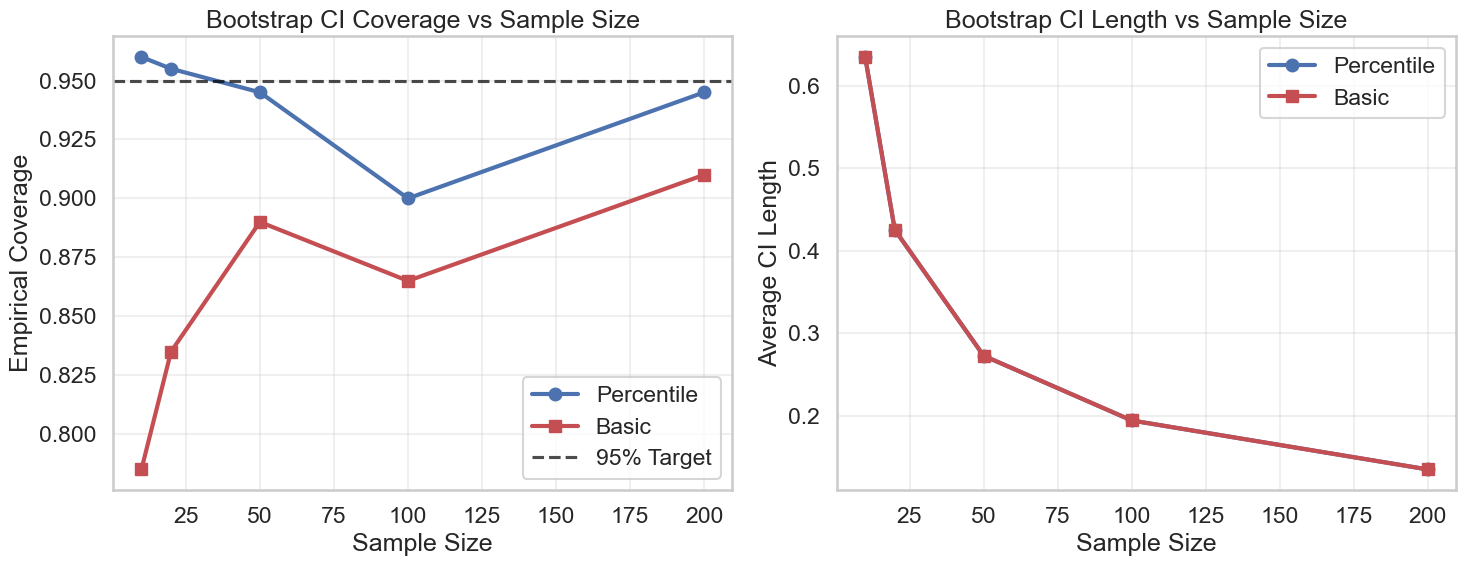

Bootstrap sample size comparison plot saved


In [51]:
# Plot bootstrap performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Coverage vs sample size
axes[0].plot(bootstrap_comparison['n'], bootstrap_comparison['percentile_coverage'], 'b-', linewidth=3, marker='o', label='Percentile')
axes[0].plot(bootstrap_comparison['n'], bootstrap_comparison['basic_coverage'], 'r-', linewidth=3, marker='s', label='Basic')
axes[0].axhline(0.95, color='black', linestyle='--', alpha=0.7, label='95% Target')
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Empirical Coverage')
axes[0].set_title('Bootstrap CI Coverage vs Sample Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Length vs sample size
axes[1].plot(bootstrap_comparison['n'], bootstrap_comparison['percentile_length'], 'b-', linewidth=3, marker='o', label='Percentile')
axes[1].plot(bootstrap_comparison['n'], bootstrap_comparison['basic_length'], 'r-', linewidth=3, marker='s', label='Basic')
axes[1].set_xlabel('Sample Size')
axes[1].set_ylabel('Average CI Length')
axes[1].set_title('Bootstrap CI Length vs Sample Size')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../slides/figures/bootstrap_sample_size_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Bootstrap sample size comparison plot saved")

## 6. Exercise Simulations

These cells reproduce the full bootstrap exercises so they can be run and adapted directly in the notebook.



### Exercise 1: Bootstrap CI for the Median (Exponential Data)



Bootstrap 95% Confidence Intervals for Median
True median: 1.3863
Sample size: n = 50
Observed median: 1.1456

------------------------------------------------------------
PERCENTILE   [0.6910, 1.6317]  Width: 0.9407  Contains true: True
BASIC        [0.6381, 1.6015]  Width: 0.9635  Contains true: True
BCA          [0.6884, 1.5824]  Width: 0.8940  Contains true: True

NORMAL APPROX [0.6112, 1.6801]  (for comparison)


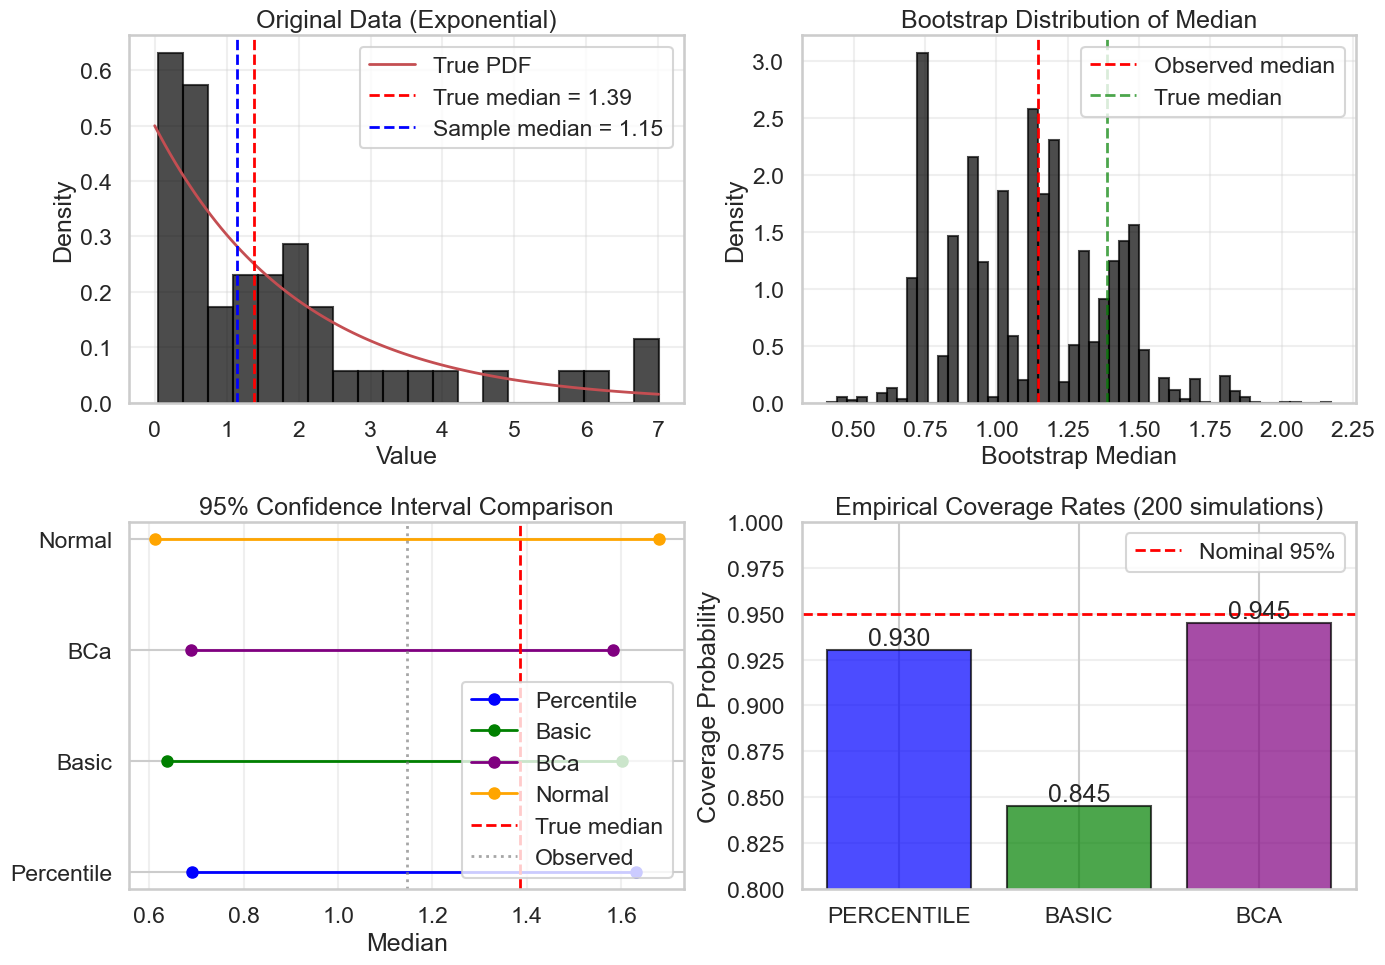

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def bootstrap_median_ci(data, n_boot=10000, confidence=0.95, method='percentile'):
    """
    Construct bootstrap CI for median.

    Parameters:
    -----------
    data : array
        Original sample
    n_boot : int
        Number of bootstrap resamples
    confidence : float
        Confidence level
    method : str
        'percentile', 'basic', or 'bca'
    """
    n = len(data)
    observed_median = np.median(data)

    # Generate bootstrap samples
    boot_medians = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(data, size=n, replace=True)
        boot_medians.append(np.median(boot_sample))

    boot_medians = np.array(boot_medians)
    alpha = 1 - confidence

    if method == 'percentile':
        # Percentile method
        ci_lower = np.percentile(boot_medians, 100 * alpha/2)
        ci_upper = np.percentile(boot_medians, 100 * (1 - alpha/2))

    elif method == 'basic':
        # Basic bootstrap (reflection method)
        ci_lower = 2*observed_median - np.percentile(boot_medians, 100 * (1 - alpha/2))
        ci_upper = 2*observed_median - np.percentile(boot_medians, 100 * alpha/2)

    elif method == 'bca':
        # Bias-corrected and accelerated (BCa) - simplified
        # This is a simplified version; full BCa requires jackknife
        z0 = stats.norm.ppf(np.mean(boot_medians < observed_median))
        z_alpha = stats.norm.ppf(alpha/2)
        z_1alpha = stats.norm.ppf(1 - alpha/2)

        # Without acceleration (a = 0), BCa reduces to BC
        p_lower = stats.norm.cdf(2*z0 + z_alpha)
        p_upper = stats.norm.cdf(2*z0 + z_1alpha)

        ci_lower = np.percentile(boot_medians, 100 * p_lower)
        ci_upper = np.percentile(boot_medians, 100 * p_upper)

    return {
        'ci': (ci_lower, ci_upper),
        'median': observed_median,
        'boot_medians': boot_medians,
        'method': method
    }

# Generate exponential data
np.random.seed(42)
true_rate = 0.5  # λ = 0.5
true_median = np.log(2) / true_rate  # Median of Exp(λ) = ln(2)/λ
n_sample = 50

data = np.random.exponential(scale=1/true_rate, size=n_sample)

# Compute CIs using different methods
methods = ['percentile', 'basic', 'bca']
results = {}

print("Bootstrap 95% Confidence Intervals for Median")
print("=" * 60)
print(f"True median: {true_median:.4f}")
print(f"Sample size: n = {n_sample}")
print(f"Observed median: {np.median(data):.4f}")
print("\n" + "-" * 60)

for method in methods:
    results[method] = bootstrap_median_ci(data, n_boot=10000, method=method)
    ci = results[method]['ci']
    width = ci[1] - ci[0]
    contains_true = ci[0] <= true_median <= ci[1]

    print(f"{method.upper():<12} [{ci[0]:.4f}, {ci[1]:.4f}]  "
          f"Width: {width:.4f}  Contains true: {contains_true}")

# Theoretical comparison (if possible)
# For exponential, median = ln(2)/λ
# Asymptotic SE ≈ 1/(2λ f(median)) = 1/(2λ · λ·exp(-λ·median))
# This is complex, so we'll use numerical bootstrap SE
boot_se = np.std(results['percentile']['boot_medians'])
theoretical_ci = (
    np.median(data) - 1.96 * boot_se,
    np.median(data) + 1.96 * boot_se
)

print(f"\nNORMAL APPROX [{theoretical_ci[0]:.4f}, {theoretical_ci[1]:.4f}]  "
      f"(for comparison)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original data
axes[0, 0].hist(data, bins=20, density=True, alpha=0.7, edgecolor='black')
x_range = np.linspace(0, data.max(), 100)
axes[0, 0].plot(x_range, true_rate * np.exp(-true_rate * x_range),
               'r-', linewidth=2, label='True PDF')
axes[0, 0].axvline(true_median, color='red', linestyle='--',
                  linewidth=2, label=f'True median = {true_median:.2f}')
axes[0, 0].axvline(np.median(data), color='blue', linestyle='--',
                  linewidth=2, label=f'Sample median = {np.median(data):.2f}')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original Data (Exponential)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Bootstrap distribution
boot_medians = results['percentile']['boot_medians']
axes[0, 1].hist(boot_medians, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(np.median(data), color='red', linestyle='--',
                  linewidth=2, label='Observed median')
axes[0, 1].axvline(true_median, color='green', linestyle='--',
                  linewidth=2, label='True median', alpha=0.7)
axes[0, 1].set_xlabel('Bootstrap Median')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Bootstrap Distribution of Median')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CI comparison
methods_plot = ['Percentile', 'Basic', 'BCa', 'Normal']
colors = ['blue', 'green', 'purple', 'orange']

for i, (method, color) in enumerate(zip(['percentile', 'basic', 'bca'], colors[:3])):
    ci = results[method]['ci']
    axes[1, 0].plot([ci[0], ci[1]], [i, i], 'o-', linewidth=2,
                   markersize=8, color=color, label=methods_plot[i])

axes[1, 0].plot([theoretical_ci[0], theoretical_ci[1]], [3, 3], 'o-',
               linewidth=2, markersize=8, color=colors[3], label='Normal')
axes[1, 0].axvline(true_median, color='red', linestyle='--',
                  linewidth=2, label='True median')
axes[1, 0].axvline(np.median(data), color='gray', linestyle=':',
                  linewidth=2, alpha=0.7, label='Observed')
axes[1, 0].set_yticks(range(4))
axes[1, 0].set_yticklabels(methods_plot)
axes[1, 0].set_xlabel('Median')
axes[1, 0].set_title('95% Confidence Interval Comparison')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Coverage simulation
def coverage_simulation(true_lambda, n, n_sims=1000):
    """Simulate coverage probability of different methods."""
    true_median = np.log(2) / true_lambda
    coverage = {method: 0 for method in methods}

    for _ in range(n_sims):
        sample = np.random.exponential(scale=1/true_lambda, size=n)

        for method in methods:
            result = bootstrap_median_ci(sample, n_boot=500, method=method)
            ci = result['ci']
            if ci[0] <= true_median <= ci[1]:
                coverage[method] += 1

    return {method: count/n_sims for method, count in coverage.items()}

# Run coverage simulation
coverage_rates = coverage_simulation(true_rate, n_sample, n_sims=200)

methods_names = [m.upper() for m in methods]
coverage_values = [coverage_rates[m] for m in methods]
colors_bar = colors[:len(methods)]

bars = axes[1, 1].bar(methods_names, coverage_values, color=colors_bar, alpha=0.7,
                     edgecolor='black')
axes[1, 1].axhline(y=0.95, color='red', linestyle='--', linewidth=2,
                  label='Nominal 95%')
axes[1, 1].set_ylabel('Coverage Probability')
axes[1, 1].set_title('Empirical Coverage Rates (200 simulations)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim([0.8, 1.0])

# Add value labels on bars
for bar, value in zip(bars, coverage_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Exercise 2: Bootstrap vs Welch's t-Interval



Comparison: Bootstrap vs Welch's t-Interval

Group A: n = 7, mean = 173.29, std = 8.73
Group B: n = 3, mean = 163.00, std = 5.57

Difference (A - B): 10.2857

----------------------------------------------------------------------
Method               Lower        Upper        Width     
----------------------------------------------------------------------
Welch t-interval     -0.9177      21.4891      22.4067   
Bootstrap            2.2857       17.9048      15.6190   

Welch df: 6.16
Welch SE: 4.6070
Bootstrap SE: 4.0132


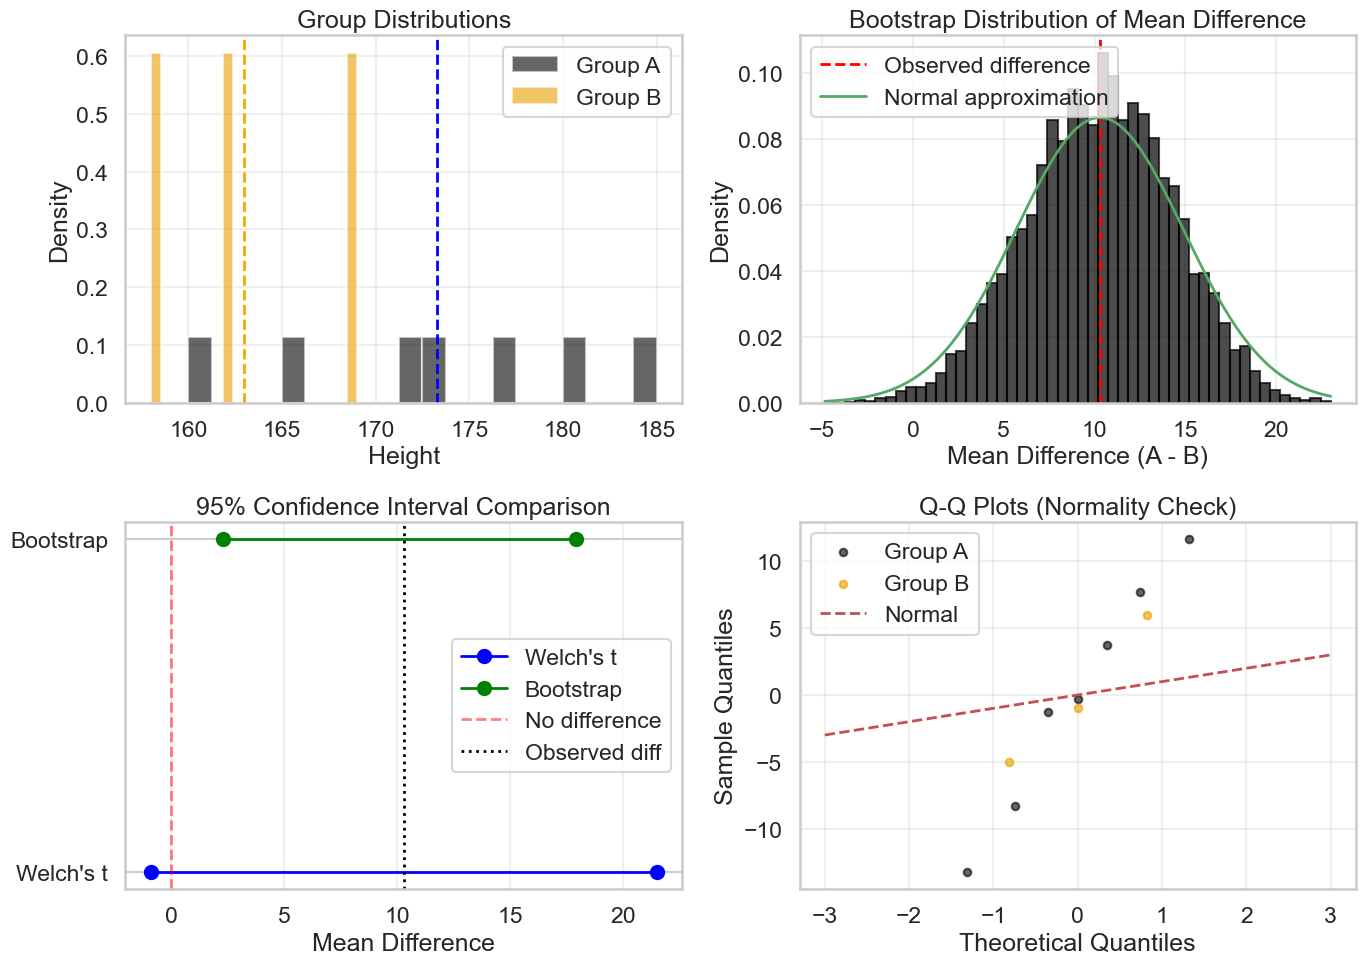


Conclusion: No significant difference detected (α = 0.05)


In [53]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('../../../shared/data/heights_weights_sample.csv')

# Suppose we want to compare heights by gender (if available)
# Or create two groups by splitting the data
np.random.seed(42)
n = len(data)
group = np.random.choice(['A', 'B'], size=n)
data['Group'] = group

group_a = data[data['Group'] == 'A']['height_cm'].values
group_b = data[data['Group'] == 'B']['height_cm'].values

def welch_t_interval(x, y, confidence=0.95):
    """
    Welch's t-interval for difference in means (unequal variances).
    """
    n1, n2 = len(x), len(y)
    mean1, mean2 = np.mean(x), np.mean(y)
    var1, var2 = np.var(x, ddof=1), np.var(y, ddof=1)

    # Difference in means
    diff = mean1 - mean2

    # Standard error
    se = np.sqrt(var1/n1 + var2/n2)

    # Welch-Satterthwaite degrees of freedom
    df = (var1/n1 + var2/n2)**2 / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))

    # Critical value
    alpha = 1 - confidence
    t_crit = stats.t.ppf(1 - alpha/2, df=df)

    # Confidence interval
    ci = (diff - t_crit * se, diff + t_crit * se)

    return ci, diff, se, df

def bootstrap_mean_diff_ci(x, y, n_boot=10000, confidence=0.95):
    """
    Bootstrap CI for difference in means.
    """
    n1, n2 = len(x), len(y)
    observed_diff = np.mean(x) - np.mean(y)

    boot_diffs = []
    for _ in range(n_boot):
        boot_x = np.random.choice(x, size=n1, replace=True)
        boot_y = np.random.choice(y, size=n2, replace=True)
        boot_diffs.append(np.mean(boot_x) - np.mean(boot_y))

    boot_diffs = np.array(boot_diffs)
    alpha = 1 - confidence

    # Percentile method
    ci = (np.percentile(boot_diffs, 100*alpha/2),
          np.percentile(boot_diffs, 100*(1-alpha/2)))

    return ci, observed_diff, boot_diffs

# Compute both intervals
welch_ci, welch_diff, welch_se, welch_df = welch_t_interval(group_a, group_b)
boot_ci, boot_diff, boot_diffs = bootstrap_mean_diff_ci(group_a, group_b)

# Display results
print("Comparison: Bootstrap vs Welch's t-Interval")
print("=" * 70)
print(f"\nGroup A: n = {len(group_a)}, mean = {np.mean(group_a):.2f}, "
      f"std = {np.std(group_a, ddof=1):.2f}")
print(f"Group B: n = {len(group_b)}, mean = {np.mean(group_b):.2f}, "
      f"std = {np.std(group_b, ddof=1):.2f}")
print(f"\nDifference (A - B): {welch_diff:.4f}")

print("\n" + "-" * 70)
print(f"{'Method':<20} {'Lower':<12} {'Upper':<12} {'Width':<10}")
print("-" * 70)
print(f"{'Welch t-interval':<20} {welch_ci[0]:<12.4f} {welch_ci[1]:<12.4f} "
      f"{welch_ci[1]-welch_ci[0]:<10.4f}")
print(f"{'Bootstrap':<20} {boot_ci[0]:<12.4f} {boot_ci[1]:<12.4f} "
      f"{boot_ci[1]-boot_ci[0]:<10.4f}")

print(f"\nWelch df: {welch_df:.2f}")
print(f"Welch SE: {welch_se:.4f}")
print(f"Bootstrap SE: {np.std(boot_diffs):.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original distributions
axes[0, 0].hist(group_a, bins=20, alpha=0.6, label='Group A', density=True)
axes[0, 0].hist(group_b, bins=20, alpha=0.6, label='Group B', density=True)
axes[0, 0].axvline(np.mean(group_a), color='blue', linestyle='--', linewidth=2)
axes[0, 0].axvline(np.mean(group_b), color='orange', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Height')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Group Distributions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Bootstrap distribution
axes[0, 1].hist(boot_diffs, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(welch_diff, color='red', linestyle='--', linewidth=2,
                  label='Observed difference')

# Overlay normal approximation
x_range = np.linspace(boot_diffs.min(), boot_diffs.max(), 100)
axes[0, 1].plot(x_range,
               stats.norm.pdf(x_range, welch_diff, welch_se),
               'g-', linewidth=2, label='Normal approximation')
axes[0, 1].set_xlabel('Mean Difference (A - B)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Bootstrap Distribution of Mean Difference')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CI comparison
axes[1, 0].plot([welch_ci[0], welch_ci[1]], [0, 0], 'o-',
               linewidth=2, markersize=10, color='blue', label="Welch's t")
axes[1, 0].plot([boot_ci[0], boot_ci[1]], [1, 1], 'o-',
               linewidth=2, markersize=10, color='green', label='Bootstrap')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2,
                  label='No difference', alpha=0.5)
axes[1, 0].axvline(welch_diff, color='black', linestyle=':',
                  linewidth=2, label='Observed diff')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(["Welch's t", 'Bootstrap'])
axes[1, 0].set_xlabel('Mean Difference')
axes[1, 0].set_title('95% Confidence Interval Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Q-Q plots to check normality assumptions
from scipy.stats import probplot

axes[1, 1].scatter(*probplot(group_a - np.mean(group_a), dist='norm')[0],
                  alpha=0.6, label='Group A', s=30)
axes[1, 1].scatter(*probplot(group_b - np.mean(group_b), dist='norm')[0],
                  alpha=0.6, label='Group B', s=30)
axes[1, 1].plot([-3, 3], [-3, 3], 'r--', linewidth=2, label='Normal')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].set_title('Q-Q Plots (Normality Check)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test
if welch_ci[0] > 0 or welch_ci[1] < 0:
    print("\nConclusion: Groups differ significantly (α = 0.05)")
else:
    print("\nConclusion: No significant difference detected (α = 0.05)")


### Exercise 3: Studentized Bootstrap for the Mean



Comparison: Percentile vs Studentized Bootstrap
True mean: 4.0000
Sample mean: 3.8085
Sample size: n = 50

----------------------------------------------------------------------
Method                    Lower        Upper        Width     
----------------------------------------------------------------------
t-interval                3.1950       4.4220       1.2270    
Percentile bootstrap      3.2307       4.4086       1.1778    
Studentized bootstrap     3.2399       4.4865       1.2466    

Running coverage simulation (500 simulations)...

Empirical Coverage Rates:
----------------------------------------
T                   : 0.940
Percentile          : 0.930
Studentized         : 0.936


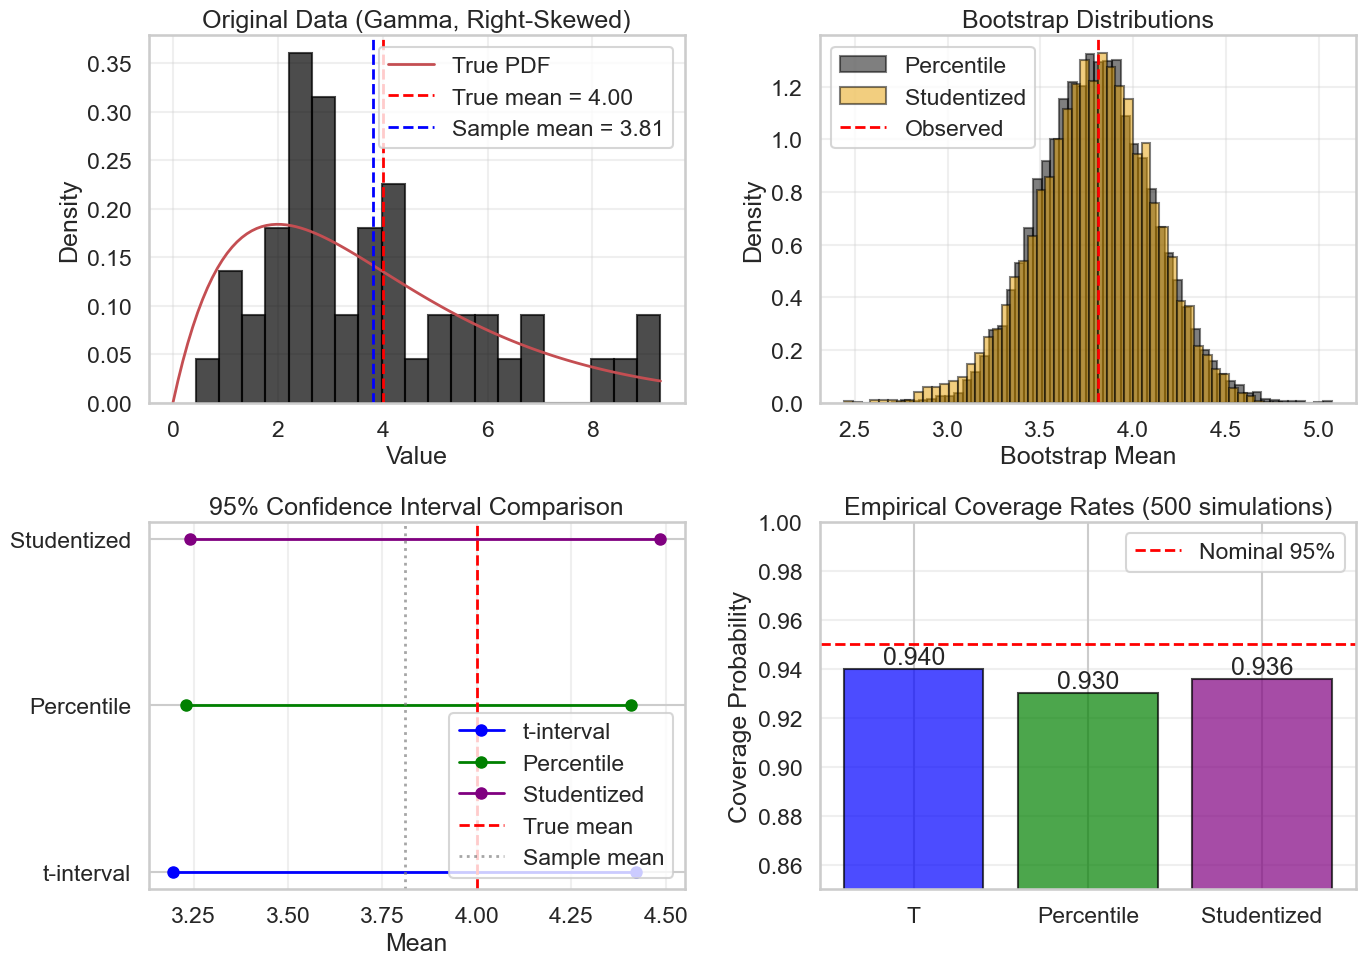

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def percentile_bootstrap(data, n_boot=10000, confidence=0.95):
    """Standard percentile bootstrap for mean."""
    n = len(data)
    observed_mean = np.mean(data)

    boot_means = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.mean(boot_sample))

    boot_means = np.array(boot_means)
    alpha = 1 - confidence

    ci = (np.percentile(boot_means, 100*alpha/2),
          np.percentile(boot_means, 100*(1-alpha/2)))

    return ci, boot_means

def studentized_bootstrap(data, n_boot=10000, confidence=0.95):
    """Studentized (bootstrap-t) for mean."""
    n = len(data)
    observed_mean = np.mean(data)
    observed_se = np.std(data, ddof=1) / np.sqrt(n)

    t_stats = []
    for _ in range(n_boot):
        # First level bootstrap
        boot_sample = np.random.choice(data, size=n, replace=True)
        boot_mean = np.mean(boot_sample)

        # Estimate SE via nested bootstrap (simplified: use sample SE)
        boot_se = np.std(boot_sample, ddof=1) / np.sqrt(n)

        # Studentized statistic
        t_stat = (boot_mean - observed_mean) / boot_se
        t_stats.append(t_stat)

    t_stats = np.array(t_stats)
    alpha = 1 - confidence

    # Find quantiles of studentized statistics
    t_lower = np.percentile(t_stats, 100*alpha/2)
    t_upper = np.percentile(t_stats, 100*(1-alpha/2))

    # Invert to get CI for mean
    ci = (observed_mean - t_upper * observed_se,
          observed_mean - t_lower * observed_se)

    return ci, t_stats

# Generate skewed data
np.random.seed(42)
data = np.random.gamma(shape=2, scale=2, size=50)  # Right-skewed
true_mean = 2 * 2  # shape * scale

# Compute CIs
perc_ci, boot_means = percentile_bootstrap(data)
stud_ci, t_stats = studentized_bootstrap(data)

# Compare with t-interval
n = len(data)
xbar = np.mean(data)
s = np.std(data, ddof=1)
t_crit = stats.t.ppf(0.975, df=n-1)
t_ci = (xbar - t_crit * s/np.sqrt(n), xbar + t_crit * s/np.sqrt(n))

print("Comparison: Percentile vs Studentized Bootstrap")
print("=" * 70)
print(f"True mean: {true_mean:.4f}")
print(f"Sample mean: {xbar:.4f}")
print(f"Sample size: n = {n}")
print("\n" + "-" * 70)
print(f"{'Method':<25} {'Lower':<12} {'Upper':<12} {'Width':<10}")
print("-" * 70)
print(f"{'t-interval':<25} {t_ci[0]:<12.4f} {t_ci[1]:<12.4f} "
      f"{t_ci[1]-t_ci[0]:<10.4f}")
print(f"{'Percentile bootstrap':<25} {perc_ci[0]:<12.4f} {perc_ci[1]:<12.4f} "
      f"{perc_ci[1]-perc_ci[0]:<10.4f}")
print(f"{'Studentized bootstrap':<25} {stud_ci[0]:<12.4f} {stud_ci[1]:<12.4f} "
      f"{stud_ci[1]-stud_ci[0]:<10.4f}")

# Coverage simulation
def coverage_simulation(true_mean, shape, scale, n, n_sims=500):
    """Simulate coverage for different methods."""
    coverage = {'t': 0, 'percentile': 0, 'studentized': 0}

    for _ in range(n_sims):
        sample = np.random.gamma(shape=shape, scale=scale, size=n)

        # t-interval
        xbar = np.mean(sample)
        s = np.std(sample, ddof=1)
        t_crit = stats.t.ppf(0.975, df=n-1)
        t_ci = (xbar - t_crit * s/np.sqrt(n), xbar + t_crit * s/np.sqrt(n))
        if t_ci[0] <= true_mean <= t_ci[1]:
            coverage['t'] += 1

        # Percentile bootstrap
        perc_ci, _ = percentile_bootstrap(sample, n_boot=1000)
        if perc_ci[0] <= true_mean <= perc_ci[1]:
            coverage['percentile'] += 1

        # Studentized bootstrap
        stud_ci, _ = studentized_bootstrap(sample, n_boot=1000)
        if stud_ci[0] <= true_mean <= stud_ci[1]:
            coverage['studentized'] += 1

    return {k: v/n_sims for k, v in coverage.items()}

print("\nRunning coverage simulation (500 simulations)...")
coverage = coverage_simulation(true_mean, shape=2, scale=2, n=50, n_sims=500)

print("\nEmpirical Coverage Rates:")
print("-" * 40)
for method, rate in coverage.items():
    print(f"{method.capitalize():<20}: {rate:.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Original data
axes[0, 0].hist(data, bins=20, density=True, alpha=0.7, edgecolor='black')
x_range = np.linspace(0, data.max(), 100)
axes[0, 0].plot(x_range, stats.gamma.pdf(x_range, a=2, scale=2),
               'r-', linewidth=2, label='True PDF')
axes[0, 0].axvline(true_mean, color='red', linestyle='--', linewidth=2,
                  label=f'True mean = {true_mean:.2f}')
axes[0, 0].axvline(xbar, color='blue', linestyle='--', linewidth=2,
                  label=f'Sample mean = {xbar:.2f}')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original Data (Gamma, Right-Skewed)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Bootstrap distributions
axes[0, 1].hist(boot_means, bins=50, density=True, alpha=0.5,
               label='Percentile', edgecolor='black')

# Overlay studentized distribution (transformed back)
stud_means_approx = xbar + t_stats * (s/np.sqrt(n))
axes[0, 1].hist(stud_means_approx, bins=50, density=True, alpha=0.5,
               label='Studentized', edgecolor='black')

axes[0, 1].axvline(xbar, color='red', linestyle='--', linewidth=2,
                  label='Observed')
axes[0, 1].set_xlabel('Bootstrap Mean')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Bootstrap Distributions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CI comparison
methods = ['t-interval', 'Percentile', 'Studentized']
cis = [t_ci, perc_ci, stud_ci]
colors = ['blue', 'green', 'purple']

for i, (method, ci, color) in enumerate(zip(methods, cis, colors)):
    axes[1, 0].plot([ci[0], ci[1]], [i, i], 'o-', linewidth=2,
                   markersize=8, color=color, label=method)

axes[1, 0].axvline(true_mean, color='red', linestyle='--', linewidth=2,
                  label='True mean')
axes[1, 0].axvline(xbar, color='gray', linestyle=':', linewidth=2,
                  alpha=0.7, label='Sample mean')
axes[1, 0].set_yticks(range(3))
axes[1, 0].set_yticklabels(methods)
axes[1, 0].set_xlabel('Mean')
axes[1, 0].set_title('95% Confidence Interval Comparison')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Coverage rates
methods_names = list(coverage.keys())
coverage_values = list(coverage.values())
colors_bar = ['blue', 'green', 'purple']

bars = axes[1, 1].bar([m.capitalize() for m in methods_names],
                     coverage_values, color=colors_bar, alpha=0.7,
                     edgecolor='black')
axes[1, 1].axhline(y=0.95, color='red', linestyle='--', linewidth=2,
                  label='Nominal 95%')
axes[1, 1].set_ylabel('Coverage Probability')
axes[1, 1].set_title('Empirical Coverage Rates (500 simulations)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim([0.85, 1.0])

for bar, value in zip(bars, coverage_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Exercise 4: Bootstrap Performance with Small Samples



Bootstrap Performance with Small Sample Sizes
n        Coverage     Mean Width     Std Width   
----------------------------------------------------------------------
5        0.840        2.908          1.046       
10       0.893        2.253          0.541       
20       0.928        1.687          0.264       
50       0.931        1.092          0.111       


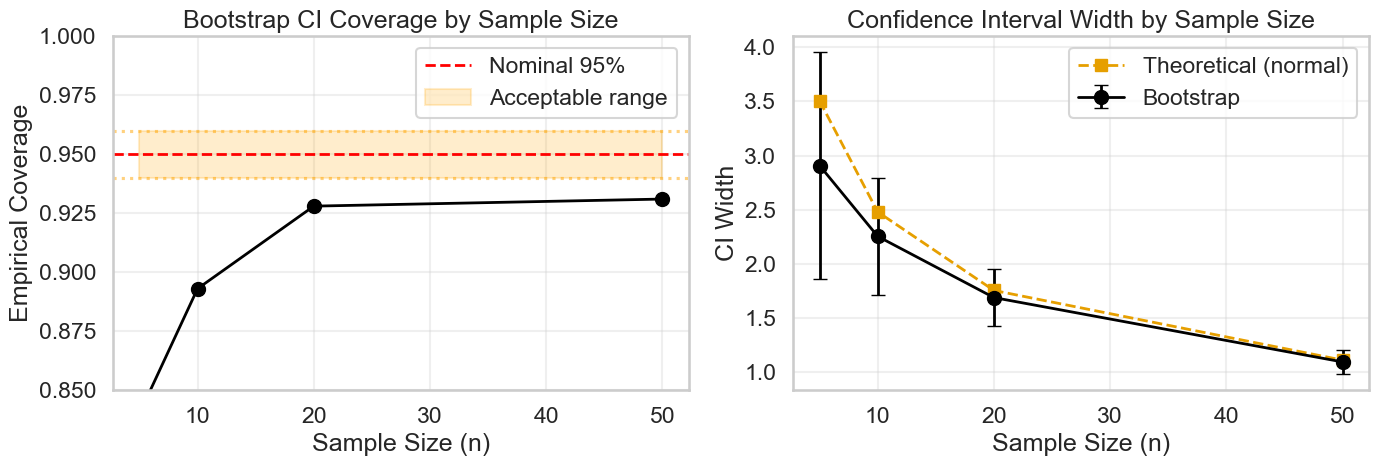


Key Findings:
• n = 5:  Poor coverage (0.840), very unstable
• n = 10: Marginal (0.893), use with caution
• n = 20: Acceptable (0.928)
• n = 50: Reliable (0.931)

Recommendation: Bootstrap requires n ≥ 20 for reliable inference


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def evaluate_bootstrap_small_n(true_mean=10, true_std=2,
                               sample_sizes=[5, 10, 20, 50],
                               n_sims=1000, n_boot=2000):
    """
    Evaluate bootstrap CI performance for small sample sizes.
    """
    results = []

    for n in sample_sizes:
        coverage = 0
        widths = []

        for _ in range(n_sims):
            # Generate sample
            sample = np.random.normal(true_mean, true_std, n)

            # Bootstrap CI
            boot_means = []
            for _ in range(n_boot):
                boot_sample = np.random.choice(sample, size=n, replace=True)
                boot_means.append(np.mean(boot_sample))

            boot_means = np.array(boot_means)
            ci = (np.percentile(boot_means, 2.5),
                  np.percentile(boot_means, 97.5))

            # Check coverage
            if ci[0] <= true_mean <= ci[1]:
                coverage += 1

            widths.append(ci[1] - ci[0])

        results.append({
            'n': n,
            'coverage': coverage / n_sims,
            'mean_width': np.mean(widths),
            'std_width': np.std(widths)
        })

    return results

# Run evaluation
print("Bootstrap Performance with Small Sample Sizes")
print("=" * 70)
results = evaluate_bootstrap_small_n()

print(f"{'n':<8} {'Coverage':<12} {'Mean Width':<14} {'Std Width':<12}")
print("-" * 70)
for r in results:
    print(f"{r['n']:<8} {r['coverage']:<12.3f} {r['mean_width']:<14.3f} "
          f"{r['std_width']:<12.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Coverage
sample_sizes = [r['n'] for r in results]
coverages = [r['coverage'] for r in results]

axes[0].plot(sample_sizes, coverages, 'o-', linewidth=2, markersize=10)
axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2,
               label='Nominal 95%')
axes[0].axhline(y=0.94, color='orange', linestyle=':', alpha=0.5)
axes[0].axhline(y=0.96, color='orange', linestyle=':', alpha=0.5)
axes[0].fill_between(sample_sizes, 0.94, 0.96, alpha=0.2, color='orange',
                    label='Acceptable range')
axes[0].set_xlabel('Sample Size (n)')
axes[0].set_ylabel('Empirical Coverage')
axes[0].set_title('Bootstrap CI Coverage by Sample Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.85, 1.0])

# Plot 2: CI width
mean_widths = [r['mean_width'] for r in results]
std_widths = [r['std_width'] for r in results]

axes[1].errorbar(sample_sizes, mean_widths, yerr=std_widths,
                fmt='o-', linewidth=2, markersize=10, capsize=5,
                label='Bootstrap')

# Theoretical width for normal
theoretical_widths = [2 * 1.96 * 2 / np.sqrt(n) for n in sample_sizes]
axes[1].plot(sample_sizes, theoretical_widths, 's--', linewidth=2,
            markersize=8, label='Theoretical (normal)')

axes[1].set_xlabel('Sample Size (n)')
axes[1].set_ylabel('CI Width')
axes[1].set_title('Confidence Interval Width by Sample Size')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Key Findings:")
print("=" * 70)
print(f"• n = 5:  Poor coverage ({results[0]['coverage']:.3f}), very unstable")
print(f"• n = 10: Marginal ({results[1]['coverage']:.3f}), use with caution")
print(f"• n = 20: Acceptable ({results[2]['coverage']:.3f})")
print(f"• n = 50: Reliable ({results[3]['coverage']:.3f})")
print("\nRecommendation: Bootstrap requires n ≥ 20 for reliable inference")


## 7. Summary and Key Takeaways

This notebook demonstrated:
1. Bootstrap for non-smooth statistics like the median
2. Bootstrap for two-sample problems using heights data
3. Comparison of different bootstrap CI methods
4. How bootstrap performance improves with sample size

Key insights:
- Bootstrap provides robust inference without parametric assumptions
- Percentile and basic intervals are easy to implement and interpret
- Bootstrap excels for complex statistics where parametric methods fail
- Performance improves with larger sample sizes and more resamples
- Heights data provides realistic examples for two-sample inference